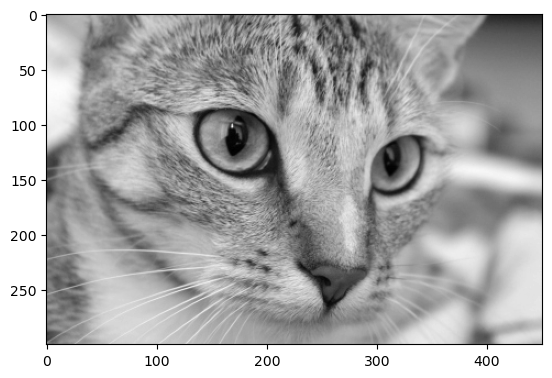

In [1]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
import skimage.color
# reading the image
img = skimage.data.chelsea()
# converting the image into gray
img = skimage.color.rgb2gray(img)
# Display the grayscale image using the 'gray' colormap
plt.imshow(img, cmap='gray')
plt.show()

In [140]:
l1_filter = numpy.zeros((2,3,3)) # preparing the filters bank for the first conv later
# a zero array is created. 2 filters of size 3x3 (2=num_filters, 3=num_rows_filter, 3=num_columns_filter)
# size of the filter is selected to be 2D array without depth because the imput image is gray and has no depth. 
# (for RGB with 3 channels, the filter must be depth 3)

In [142]:
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]])  
l1_filter[1, :, :] = numpy.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]]) 
# the size of the filters bank is specified by the above zero array but not the acrual values of the filters.
# it is possible to override such values as follows to detect vertical and horizontal edges.

In [144]:
def conv(img, conv_filter):  
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.  
        if img.shape[-1] != conv_filter.shape[-1]:  
            print("Error: Number of channels in both image and filter must match.")  
            sys.exit()  
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.  
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
        sys.exit()  
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.  
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
        sys.exit()  
  
    # An empty feature map to hold the output of convolving the filter(s) with the image.  
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                                img.shape[1]-conv_filter.shape[1]+1,   
                                conv_filter.shape[0]))  
  
    # Convolving the image by the filter(s).  
    for filter_num in range(conv_filter.shape[0]):  
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.  
        """  
        Checking if there are mutliple channels for the single filter. 
        If so, then each channel will convolve the image. 
        The result of all convolutions are summed to return a single feature map. 
        """  
        if len(curr_filter.shape) > 2:  
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.  
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                conv_map = conv_map + conv_(img[:, :, ch_num],   
                                  curr_filter[:, :, ch_num])  
        else: # There is just a single channel in the filter.  
            conv_map = conv_(img, curr_filter)  
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.  

In [146]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[0]
    result = numpy.zeros((img.shape))
    
    # Looping through the image to apply the convolution operation.
    for r in numpy.uint16(numpy.arange(filter_size/2, img.shape[0] - filter_size/2 - 2)):
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1] - filter_size/2 - 2)):
            
            # Getting the current region to get multiplied with the filter.
            curr_region = img[r:r + filter_size, c:c + filter_size]
            
            # Element-wise multiplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.
    
    # Clipping the outliers of the result matrix.
    final_result = result[numpy.uint16(filter_size/2):result.shape[0] - numpy.uint16(filter_size/2),
                          numpy.uint16(filter_size/2):result.shape[1] - numpy.uint16(filter_size/2)]
    
    return final_result


In [148]:
# after preparing th efilters, next is to convolve the input image by them.
l1_feature_map = conv(img, l1_filter) 

Filter  1
Filter  2


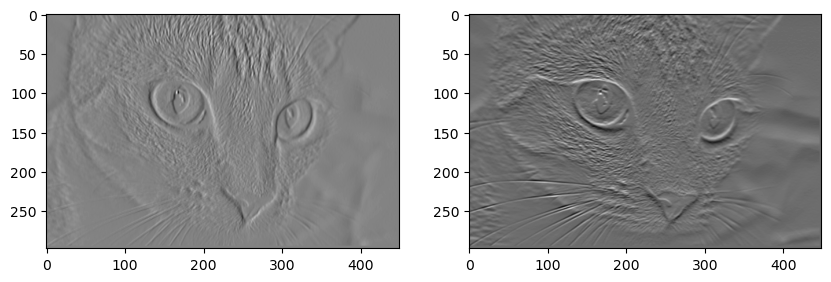

In [149]:
# l1_feature_map is the result of the convolution operation
num_filters = l1_feature_map.shape[-1]  # Number of filters (depth of the feature map)

# Plotting the feature maps
plt.figure(figsize=(10, 10))

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)  # Displaying each feature map in a subplot
    plt.imshow(l1_feature_map[:, :, i], cmap='gray')  # Displaying the feature map in grayscale

plt.show()

In [152]:
def relu(feature_map):
    # Preparing the output of the ReLU activation function.
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0, feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0)
    return relu_out


In [154]:
l1_feature_map_relu = relu(l1_feature_map)

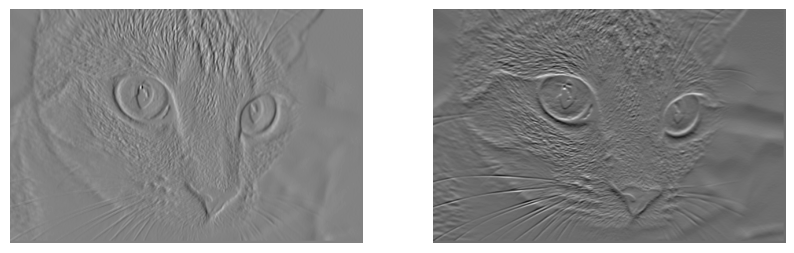

In [156]:
# Number of filters (depth of the feature map)
num_filters = l1_feature_map_relu.shape[-1]

# Plotting the ReLU-activated feature maps
plt.figure(figsize=(10, 10))

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)  # Create a subplot for each filter's feature map
    plt.imshow(l1_feature_map_relu[:, :, i], cmap='gray')  # Display each feature map in grayscale
    plt.axis('off')  # Turn off axis labels for a cleaner display

plt.show()

In [158]:
def pooling(feature_map, size=2, stride=2):
    # Preparing the output of the pooling operation.
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0] - size + 1) / stride),
                            numpy.uint16((feature_map.shape[1] - size + 1) / stride),
                            feature_map.shape[-1]))
    
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0, feature_map.shape[0] - size - 1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1] - size - 1, stride):
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size, c:c+size])
                c2 = c2 + 1
            r2 = r2 + 1
    
    return pool_out


In [160]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

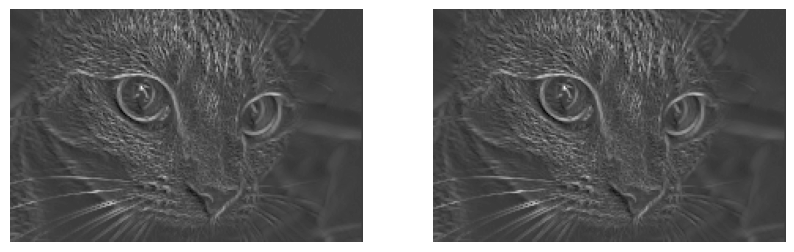

In [162]:
# Number of filters (depth of the feature map)
num_filters = l1_feature_map_relu_pool.shape[-1]

# Plotting the pooled feature maps
plt.figure(figsize=(10, 10))

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)  # Create a subplot for each filter's feature map
    plt.imshow(l1_feature_map_relu_pool[:, :, i], cmap='gray')  # Display each feature map in grayscale
    plt.axis('off')  # Turn off axis labels for cleaner display

plt.show()

In [164]:
# Second conv layer
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")



**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



In [172]:
# Third conv layer  
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])  
print("\n**Working with conv layer 3**")  
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)  
print("\n**ReLU**")  
l3_feature_map_relu = relu(l3_feature_map)  
print("\n**Pooling**")  
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)  
print("**End of conv layer 3**\n")  


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



In [174]:
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)

Filter  1
Filter  2
Filter  3
Filter  1


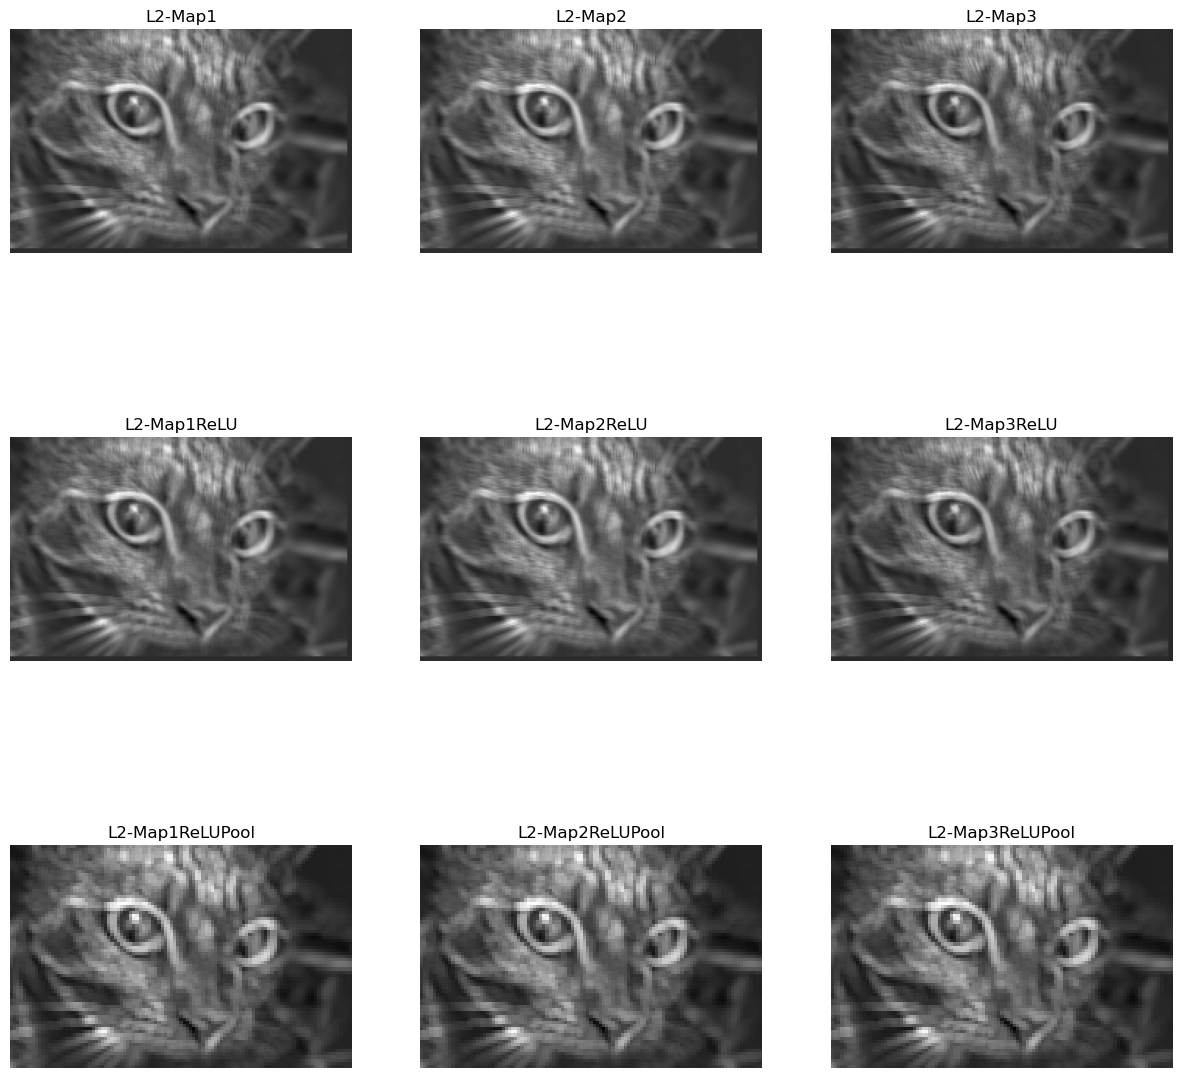

In [178]:
plt.figure(figsize=(15, 15))

for i in range(num_filters):
    # Step 1: Original feature map (after convolution)
    plt.subplot(3, num_filters, i + 1)
    plt.imshow(l2_feature_map[:, :, i], cmap='gray')
    plt.title(f'L2-Map{i+1}')
    plt.axis('off')
    
    # Step 2: ReLU activated feature map
    plt.subplot(3, num_filters, num_filters + i + 1)
    plt.imshow(l2_feature_map_relu[:, :, i], cmap='gray')
    plt.title(f'L2-Map{i+1}ReLU')
    plt.axis('off')
    
    # Step 3: Pooled feature map after ReLU
    plt.subplot(3, num_filters, 2*num_filters + i + 1)
    plt.imshow(l2_feature_map_relu_pool[:, :, i], cmap='gray')
    plt.title(f'L2-Map{i+1}ReLUPool')
    plt.axis('off')

plt.show()

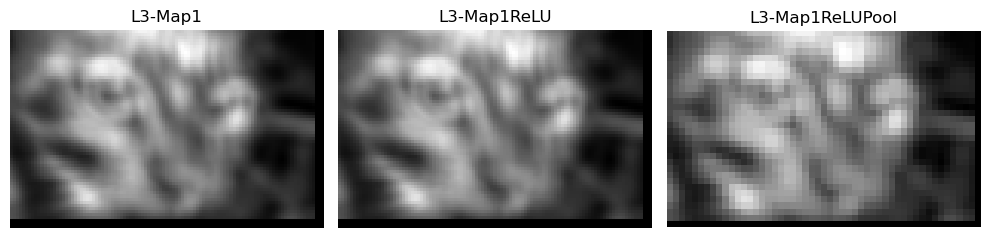

In [180]:
num_filters = l3_feature_map.shape[-1]  # Number of filters in the third convolution layer

plt.figure(figsize=(10, 5))  # Adjust the size based on how large you want the image

for i in range(num_filters):
    # Step 1: Original feature map (after convolution)
    plt.subplot(1, 3, 1)
    plt.imshow(l3_feature_map[:, :, i], cmap='gray')
    plt.title(f'L3-Map{i+1}')
    plt.axis('off')
    
    # Step 2: ReLU activated feature map
    plt.subplot(1, 3, 2)
    plt.imshow(l3_feature_map_relu[:, :, i], cmap='gray')
    plt.title(f'L3-Map{i+1}ReLU')
    plt.axis('off')
    
    # Step 3: Pooled feature map after ReLU
    plt.subplot(1, 3, 3)
    plt.imshow(l3_feature_map_relu_pool[:, :, i], cmap='gray')
    plt.title(f'L3-Map{i+1}ReLUPool')
    plt.axis('off')

plt.tight_layout()  # Adjust layout to avoid overlap of titles and images
plt.show()